# Shooting Method

In [1]:
import numpy as np
from scipy import integrate, optimize
from matplotlib import pyplot as plt

# Default configuaration for matplotlib
import scienceplots
plt.style.use(['science','ieee'])
plt.rcParams["figure.figsize"] = (10, 6)

# Natural units
hbar = m = 1

In [2]:
# Euler method for solving differential equations
def euler(ypp, xi, xf, yi, ypi, n=1000, args=None):
    x, dx = np.linspace(xi, xf, n, retstep=True)

    yp = np.empty(n)
    y = np.empty(n)

    yp[0] = ypi
    y[0] = yi

    for i in range(1, n):
        yp[i] = yp[i-1] + dx * ypp(x[i], y[i-1], yp[i-1], *args)
        y[i] = y[i-1] + dx * yp[i-1]

    return x, y

## Boundary-value Problems

In [3]:
# Function for solving Schrodinger's equation using shooting method
def solve_bvp(ypp, xi, xf, yi, yf, ypi_i, ypi_f, ypi_h, args=None):
    ypi = np.arange(ypi_i, ypi_f, ypi_h)
    Y_f = np.empty(ypi.size)
    
    for i in range(ypi.size):
        x, y = euler(ypp, xi, xf, yi, ypi[i], args=args)
        Y_f[i] = y[-1]

        if i and (Y_f[i] - yf) * (Y_f[i-1] - yf) < 0:
            return x, ypi[i], y

### Legrende Differential Equation

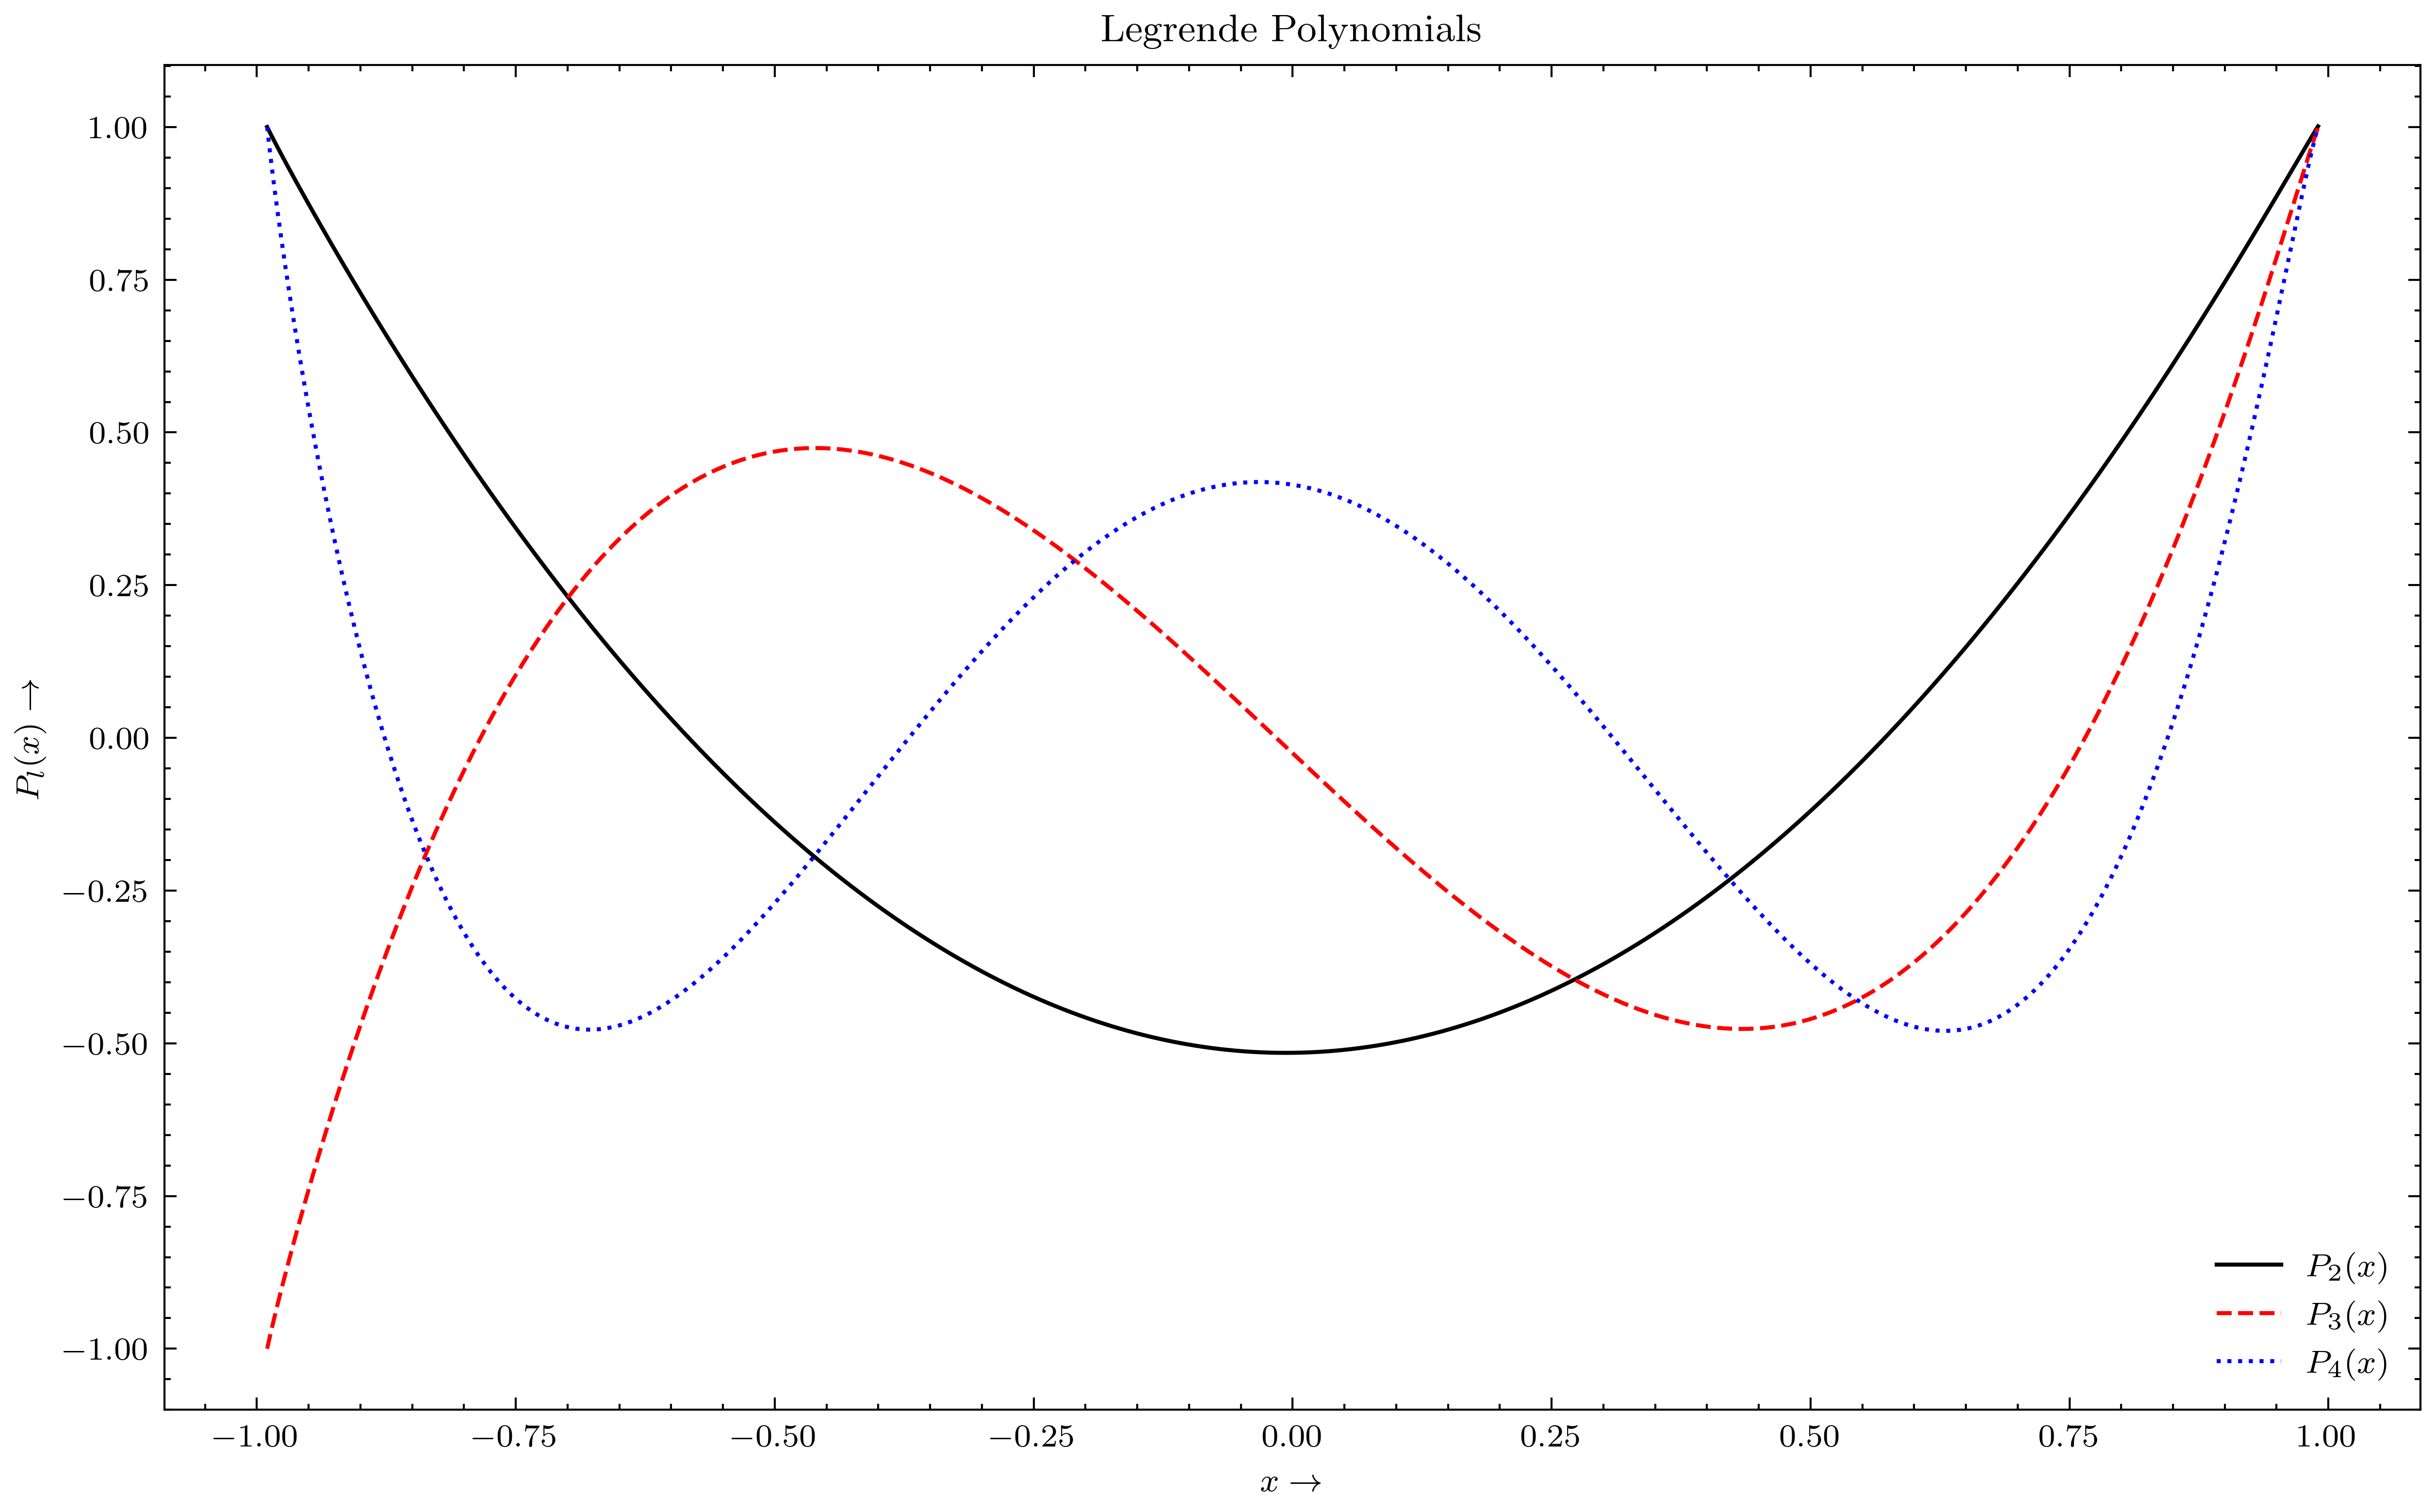

In [4]:
def ypp(x, y, yp, l):
    return (2 * x * yp - l * (l + 1) * y) / (1 - x**2)

ypi_i, ypi_f, ypi_h = -20, 20, 0.1

l =  2, 3, 4
xi = - 0.99
xf = 0.99
yi = 1, -1, 1
yf = 1, 1, 1

for k in range(len(l)):
    x, ypi, y = solve_bvp(ypp, xi, xf, yi[k], yf[k], ypi_i, ypi_f, ypi_h, args=(l[k],))
    plt.plot(x, y, label=f"$P_{l[k]}(x)$")

plt.title("Legrende Polynomials")
plt.xlabel("$x \\rightarrow$")
plt.ylabel("$P_l(x) \\rightarrow$")
plt.legend()
plt.show()

### Hermite Differential Equation

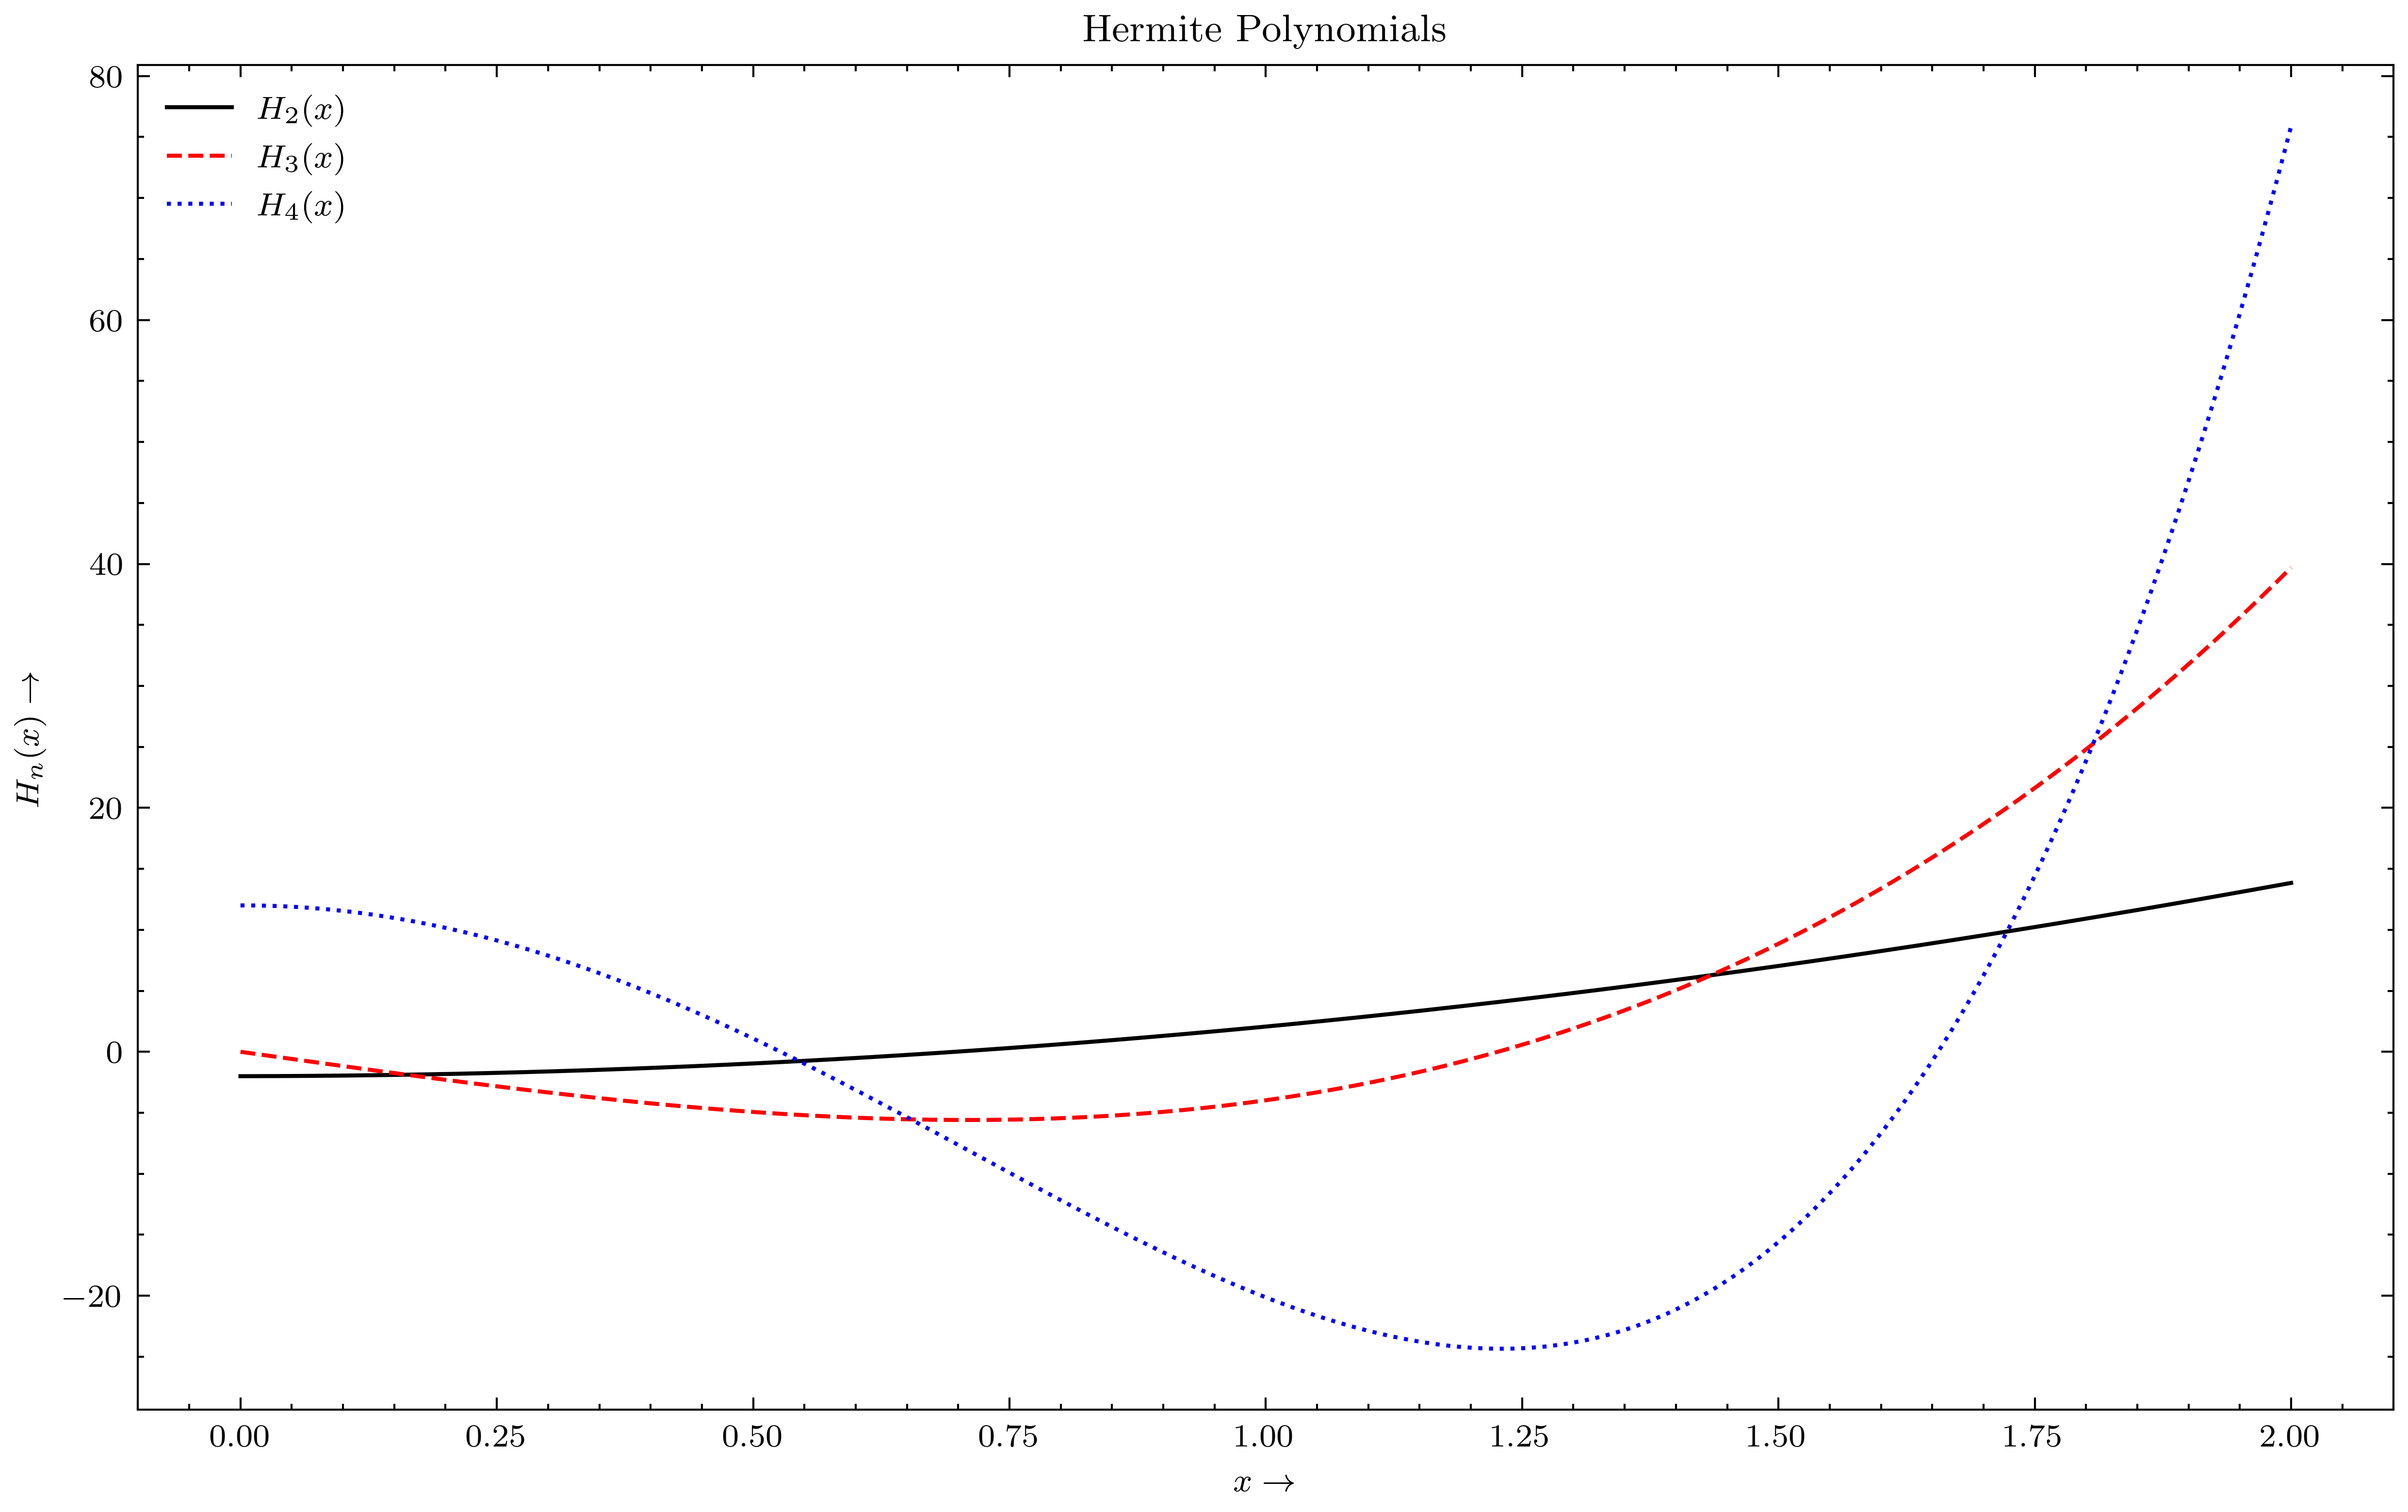

In [5]:
def ypp(x, y, yp, n):
    return 2 * x * yp - 2 * n * y

ypi_i, ypi_f, ypi_h = -20, 20, 0.1

n =  2, 3, 4
xi = 0
xf = 2
yi = -2, 0, 12
yf = 14, 40, 76

for k in range(len(n)):
    x, ypi, y = solve_bvp(ypp, xi, xf, yi[k], yf[k], ypi_i, ypi_f, ypi_h, args=(n[k],))
    plt.plot(x, y, label=f"$H_{n[k]}(x)$")

plt.title("Hermite Polynomials")
plt.xlabel("$x \\rightarrow$")
plt.ylabel("$H_n(x) \\rightarrow$")
plt.legend()
plt.show()

## Eigenvalue Problems

In [6]:
# Default configuaration for matplotlib
plt.rcParams["figure.figsize"] = (10, 15)

In [7]:
def solve_sch_eqn(ypp, xi, xf, E_n, yi=0, yf=0, ypi=1, n=1000):
    eigenvalues = np.zeros(E_n)
    eigenvectors = []
    
    eigenvalues[0] = 0

    for i in range(E_n):
        eigenvalues[i] = optimize.newton(shoot, eigenvalues[i], args=(ypp, xi, xf, yi, yf, ypi, n))
        x, y = euler(ypp, xi, xf, yi, ypi, n, args=(eigenvalues[i],))
        eigenvectors.append(y.copy())
        
        if i+1 < E_n: 
            eigenvalues[i+1] = 2 * eigenvalues[i] - (eigenvalues[i-1] if i >0 else 0) + eigenvalues[0] / (i+1)
    
    return x, eigenvalues, np.array(eigenvectors)
    

In [8]:
def shoot(E, ypp, xi, xf, yi, yf, ypi, n):
    x, y = euler(ypp, xi, xf, yi, ypi, n, args=(E,))
    
    return yf - y[-1]

In [9]:
def sch_eqn(V):
    def ypp(x, y, yp, E):
        return - (2 * m / hbar**2) * (E - V(x)) * y
    return ypp

### Infinite square potential well

$$V(x)
=
\begin{cases}
0, & -a < x < a\\
\lim\limits_{V_0 \to \infty} V_0, & \text{otherwise}
\end{cases}
$$

In [10]:
a = 1
V_0 = 1e6

@np.vectorize
def V(x):
    if -a < x < a:
        return 0.0
    else:
        return V_0

xi, xf = -1, 1
E_n = 3

x, E, psi = solve_sch_eqn(sch_eqn(V), xi, xf, E_n)

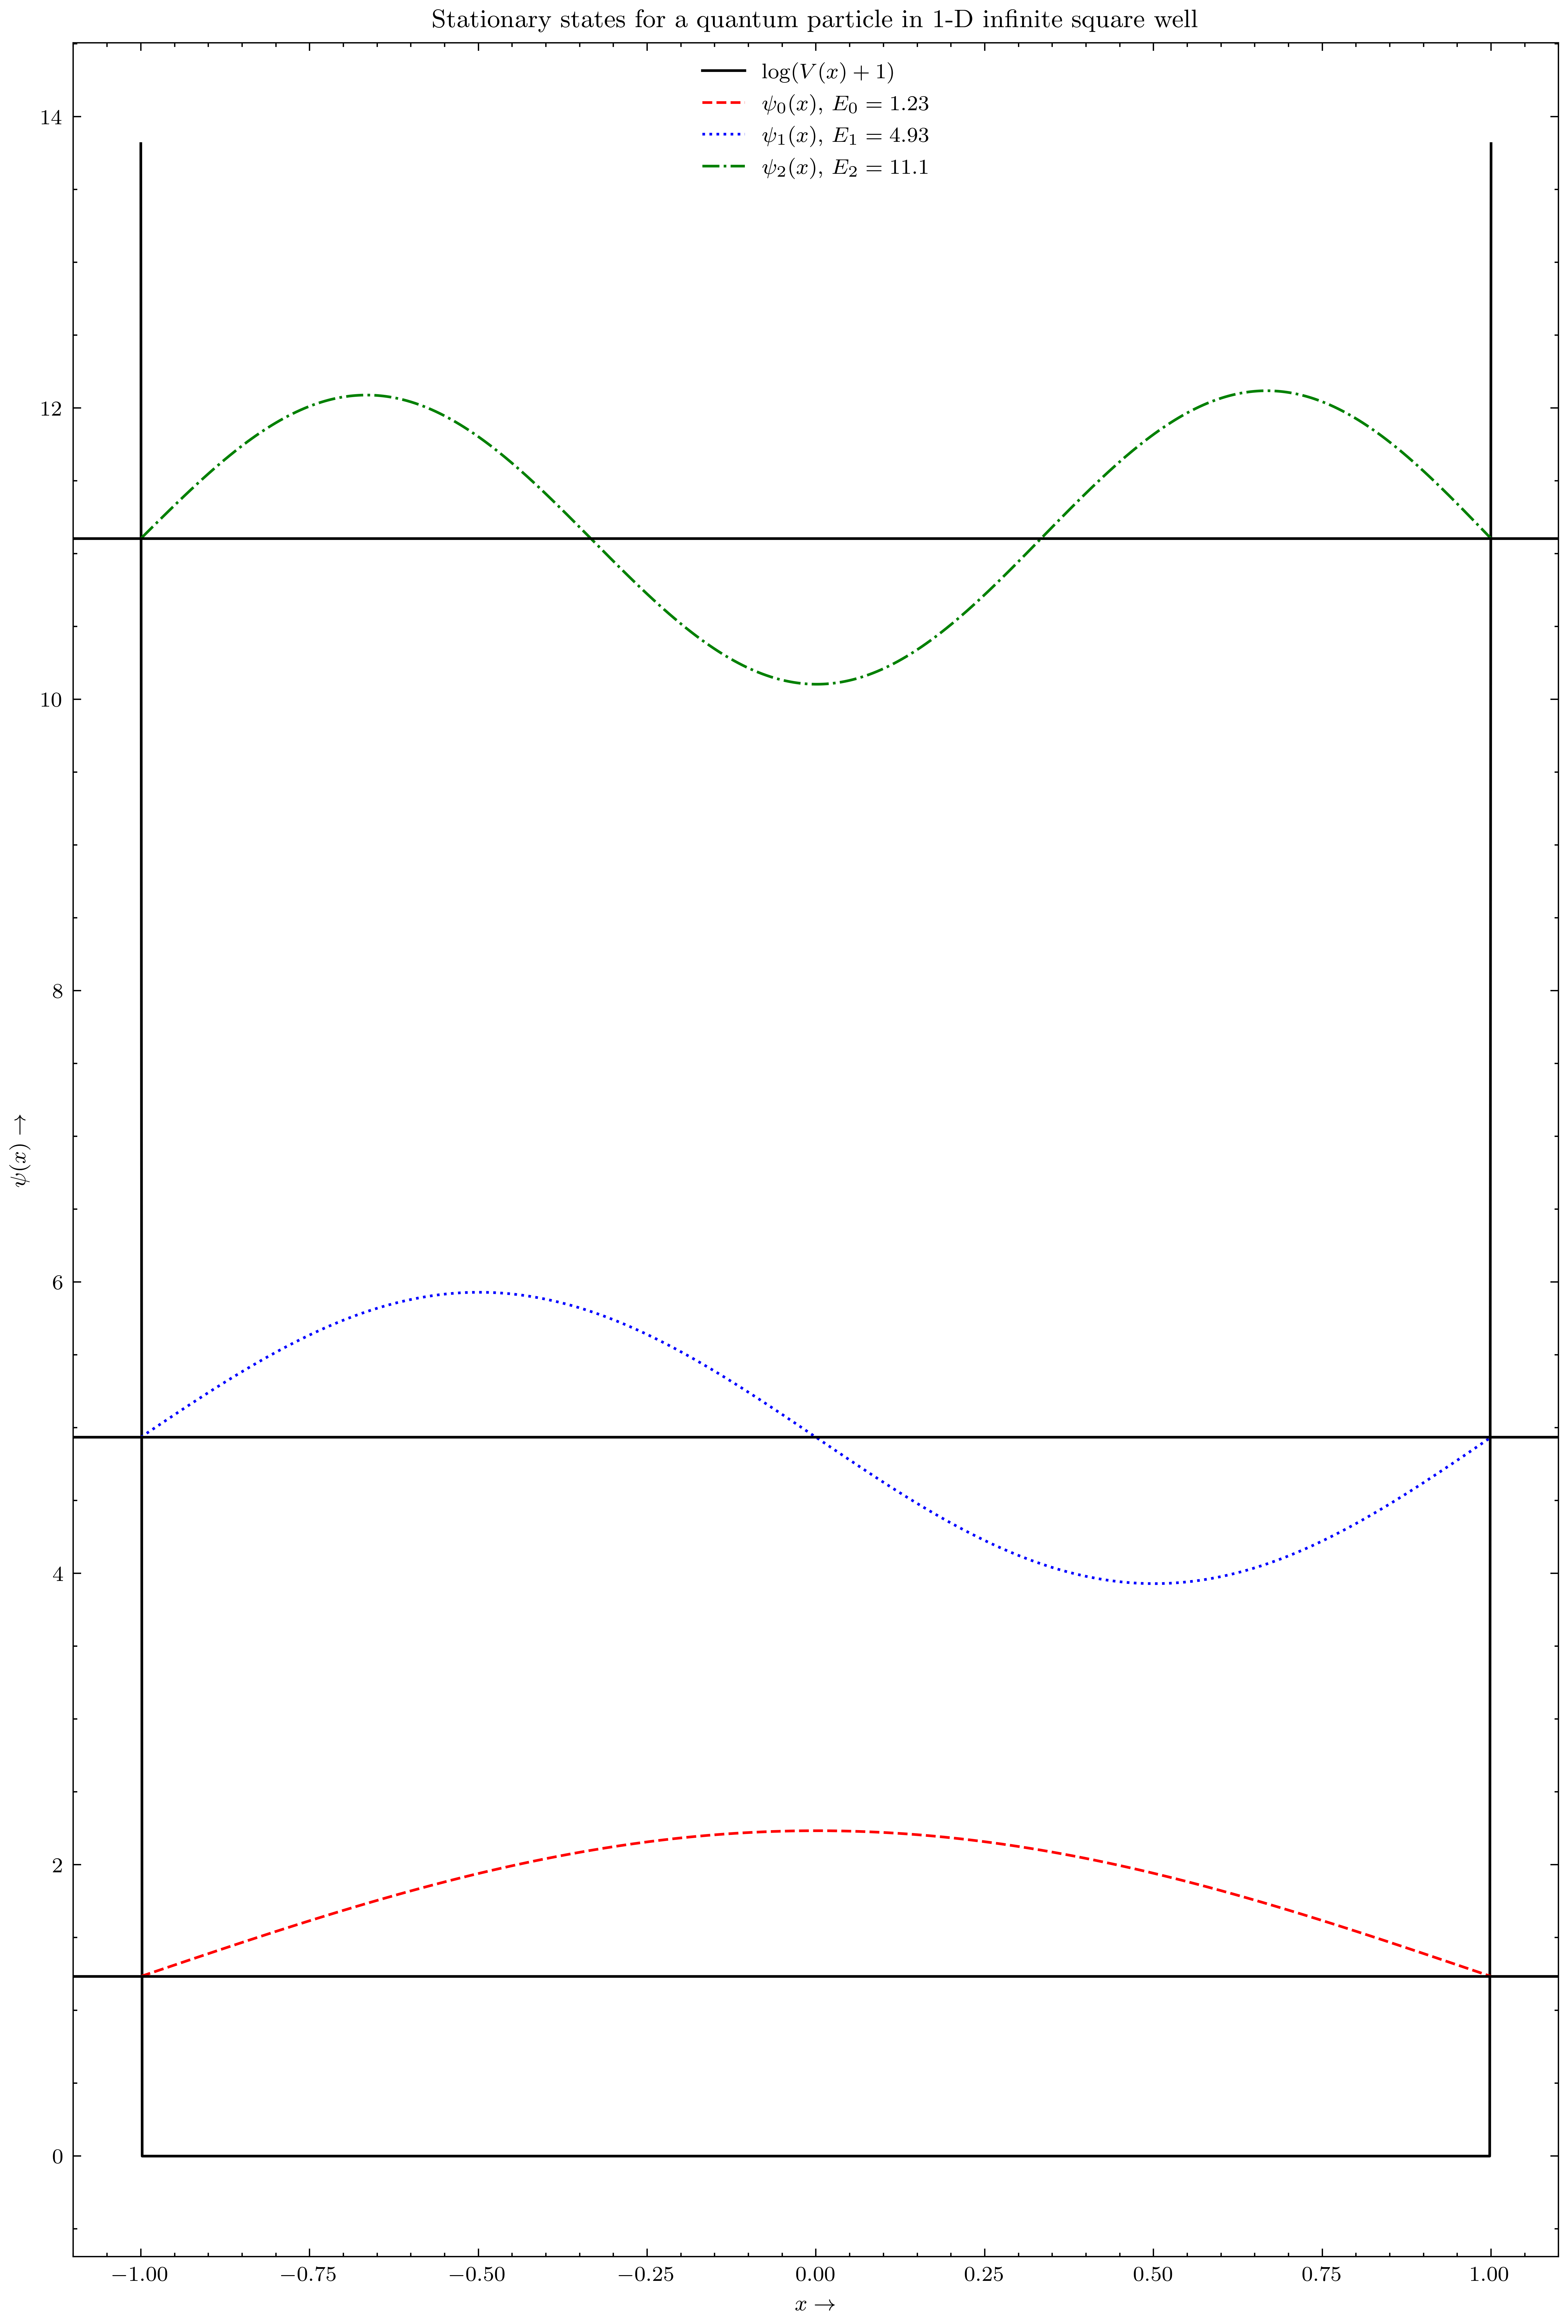

In [11]:
plt.plot(x, np.log(V(x) + 1), label="$\\log(V(x) + 1)$")

for i in range(E.size):
    plt.plot(x , E[i] + psi[i]/np.sqrt(integrate.simpson(psi[i]**2, x)), label=f"$\psi_{i}(x)$, $E_{i} = {round(E[i], 2)}$")
    plt.axhline(E[i])

plt.title("Stationary states for a quantum particle in 1-D infinite square well")
plt.xlabel("$x \\rightarrow$")
plt.ylabel("$\psi(x) \\rightarrow$")
plt.legend()
plt.show()

### Finite square potential well

$$V(x)
=
\begin{cases}
0, & -a < x < a\\
V_0, & \text{otherwise}
\end{cases}
$$

In [12]:
a = 1
V_0 = 10.0

@np.vectorize
def V(x):
    if -a < x < a:
        return 0
    else:
        return V_0

xi, xf = -2, 2
E_n = 3

x, E, psi = solve_sch_eqn(sch_eqn(V), xi, xf, E_n)

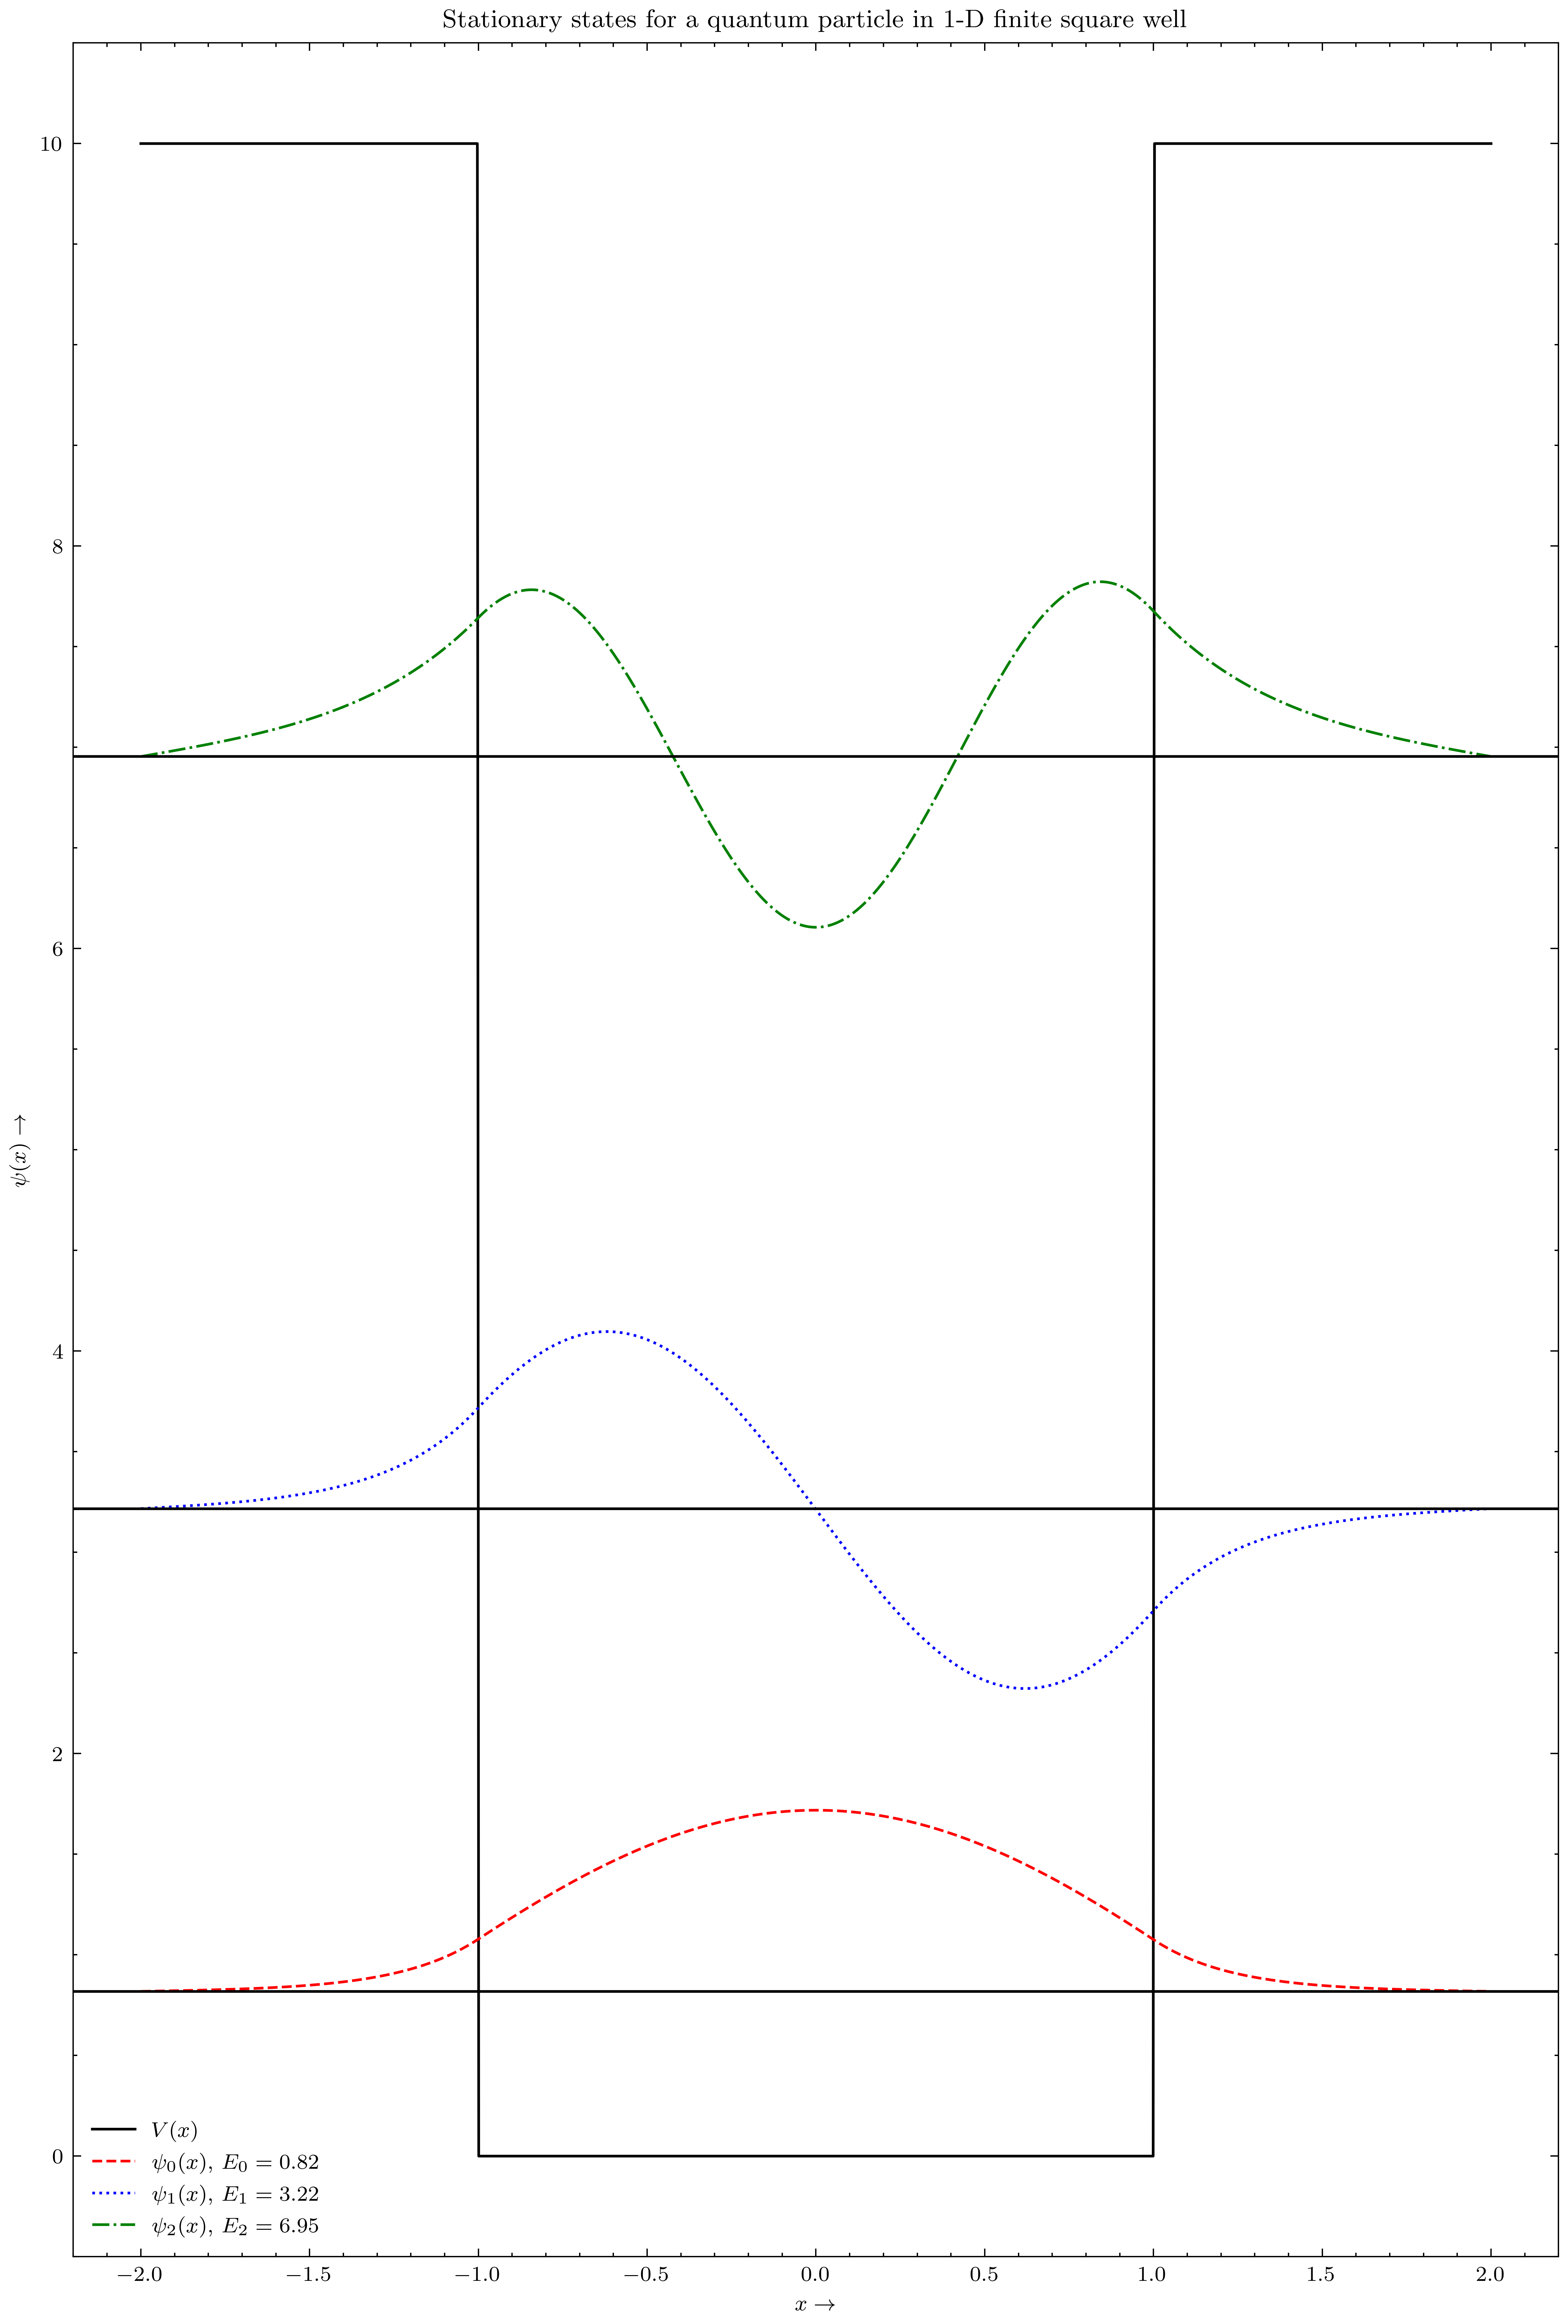

In [13]:
plt.plot(x, V(x), label="$V(x)$")

for i in range(E.size):
    plt.plot(x , E[i] + psi[i]/np.sqrt(integrate.simpson(psi[i]**2, x)), label=f"$\psi_{i}(x)$, $E_{i} = {round(E[i], 2)}$")
    plt.axhline(E[i])

plt.title("Stationary states for a quantum particle in 1-D finite square well")
plt.xlabel("$x \\rightarrow$")
plt.ylabel("$\psi(x) \\rightarrow$")
plt.legend()
plt.show()

### Step potential

$$V(x)
=
\begin{cases}
0, & x \lt 0\\
V_0, & x \ge 0
\end{cases}
$$

In [14]:
a = 1
V_0 = 10

@np.vectorize
def V(x):
    if x < 0:
        return 0.0
    else:
        return V_0

xi, xf = -2, 2
E_n = 3

x, E, psi = solve_sch_eqn(sch_eqn(V), xi, xf, E_n)

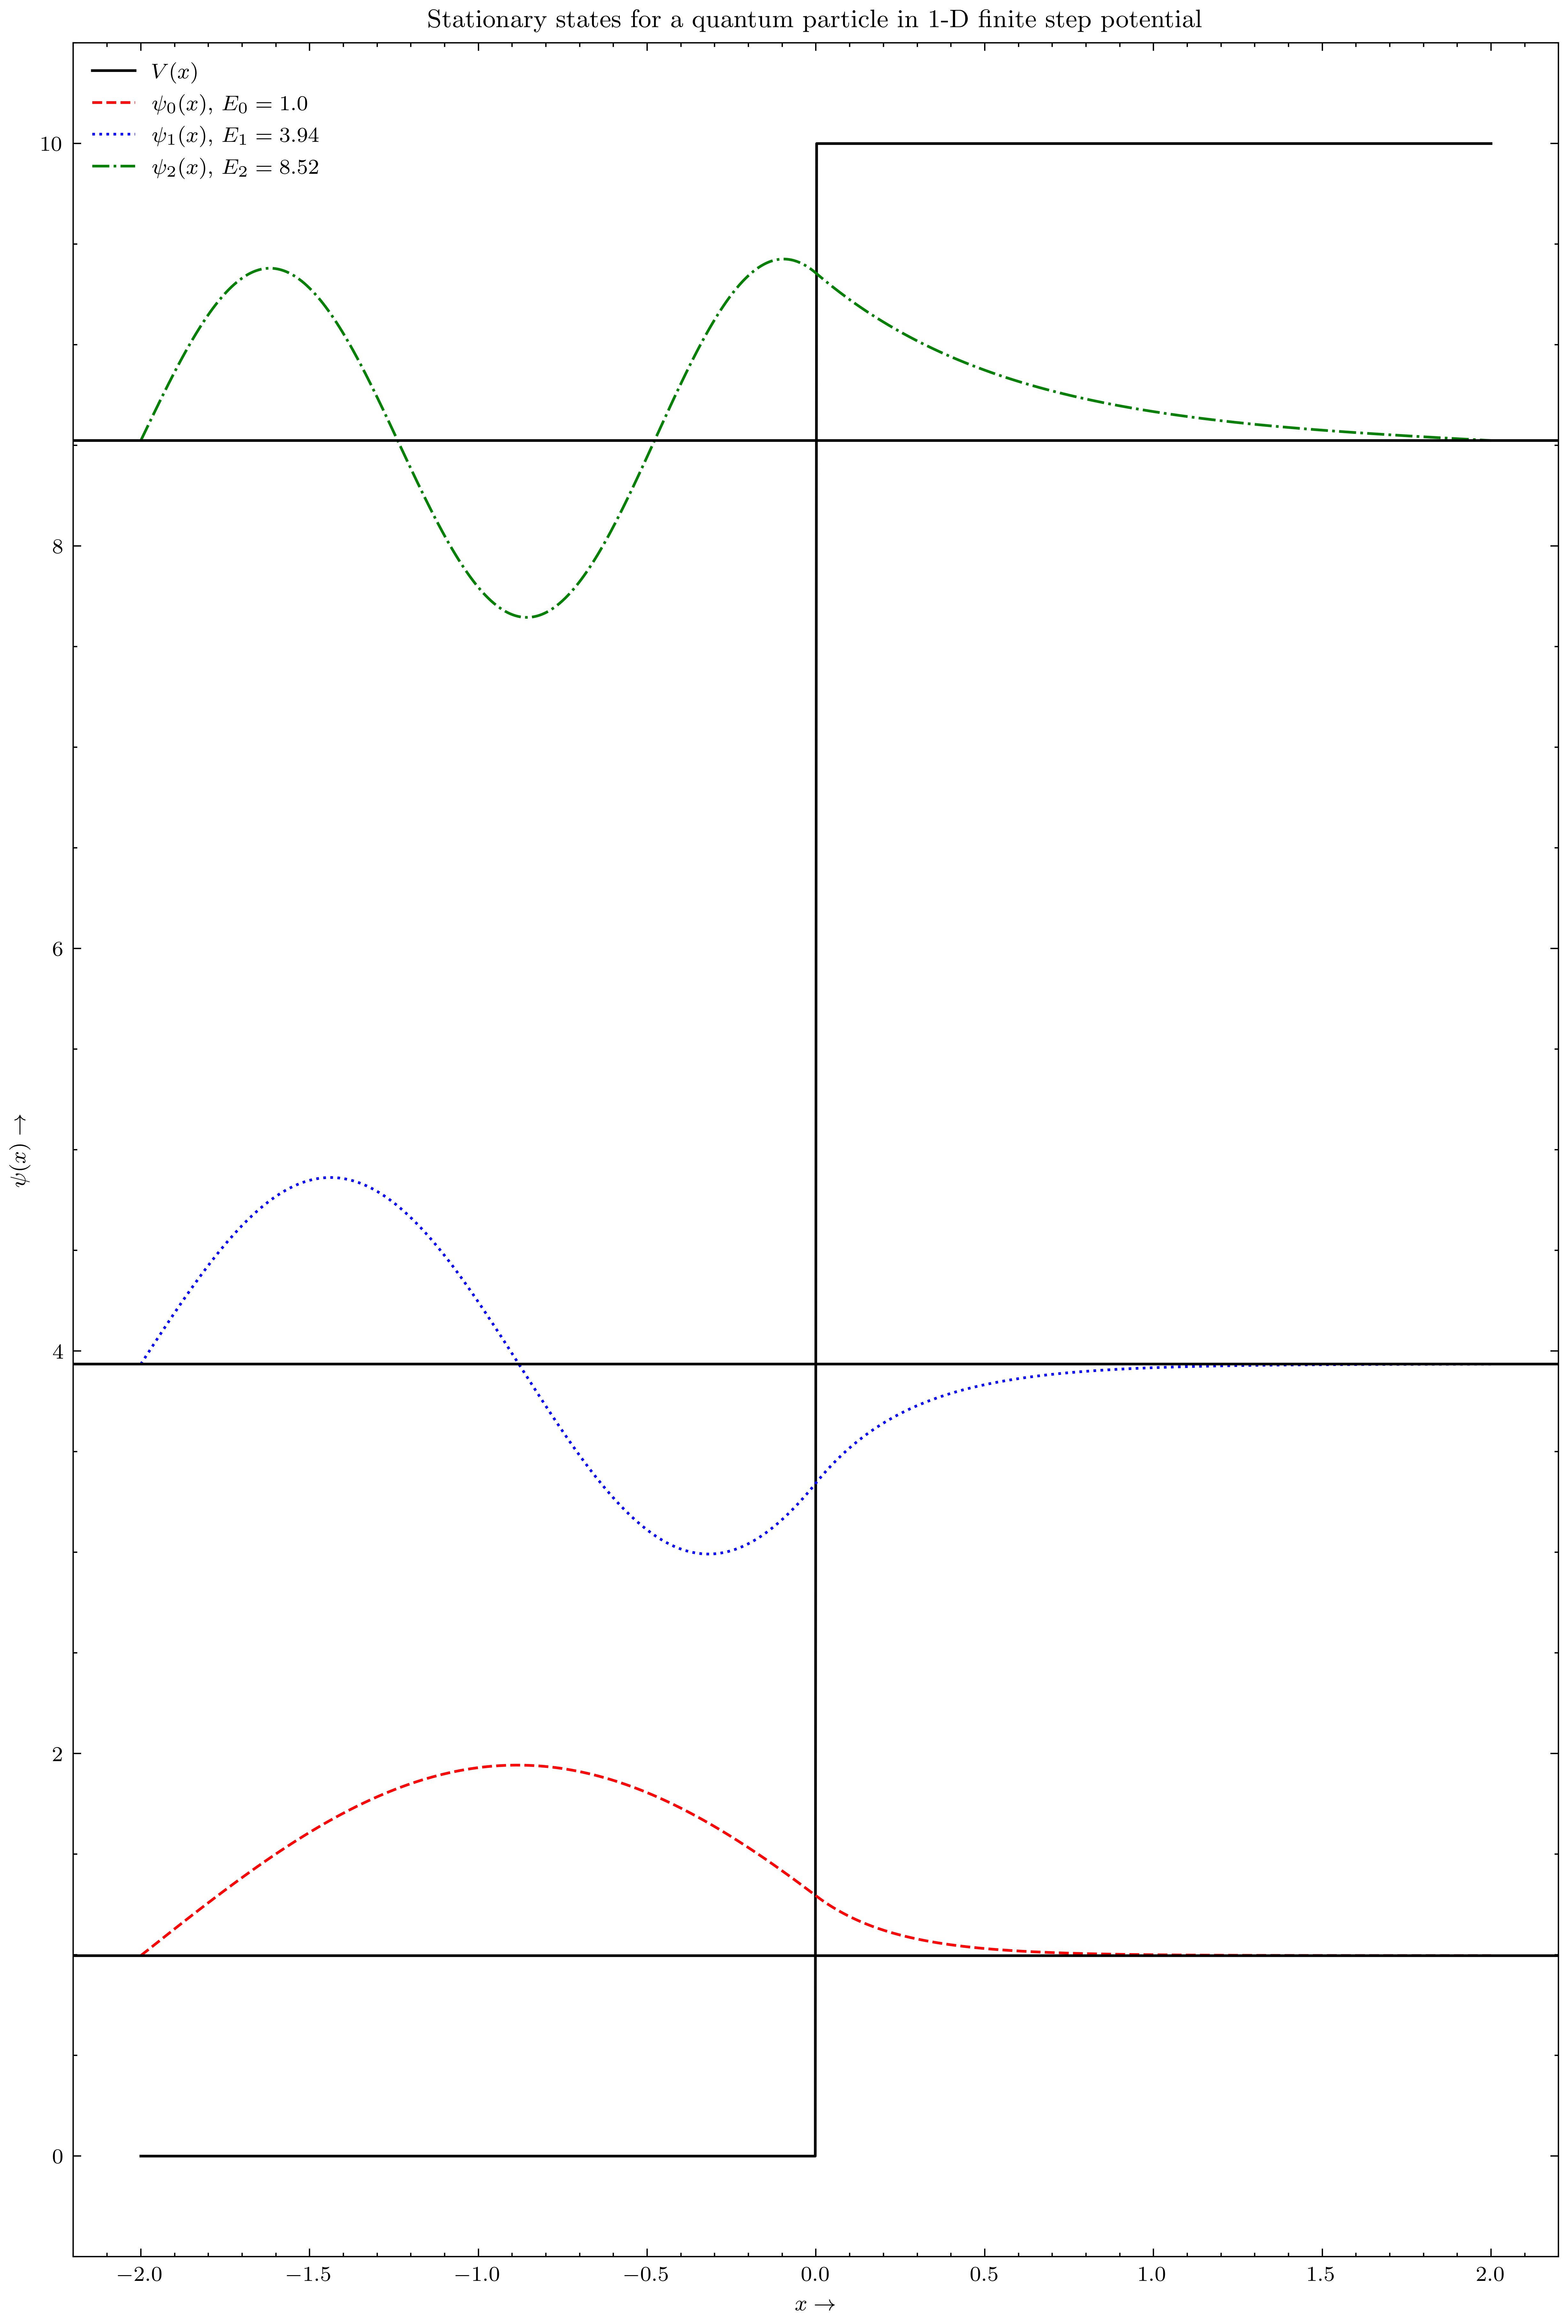

In [15]:
plt.plot(x, V(x), label="$V(x)$")

for i in range(E_n):
    plt.plot(x, E[i] + psi[i]/np.sqrt(integrate.simpson(psi[i]**2, x)), label=f"$\psi_{i}(x)$, $E_{i} = {round(E[i], 2)}$")
    plt.axhline(E[i])

plt.title("Stationary states for a quantum particle in 1-D finite step potential")
plt.xlabel("$x \\rightarrow$")
plt.ylabel("$\psi(x) \\rightarrow$")
plt.legend()
plt.show()

### Linear Harmonic Oscillator

$$V(x) = \frac{1}{2} \, m \, \omega^2 \, x^2$$

In [16]:
omega = 1.5 # angular frequency

@np.vectorize
def V(x):
    return 0.5 * m * omega**2 * x**2

xi, xf = -3, 3
E_n = 3

x, E, psi = solve_sch_eqn(sch_eqn(V), xi, xf, E_n)

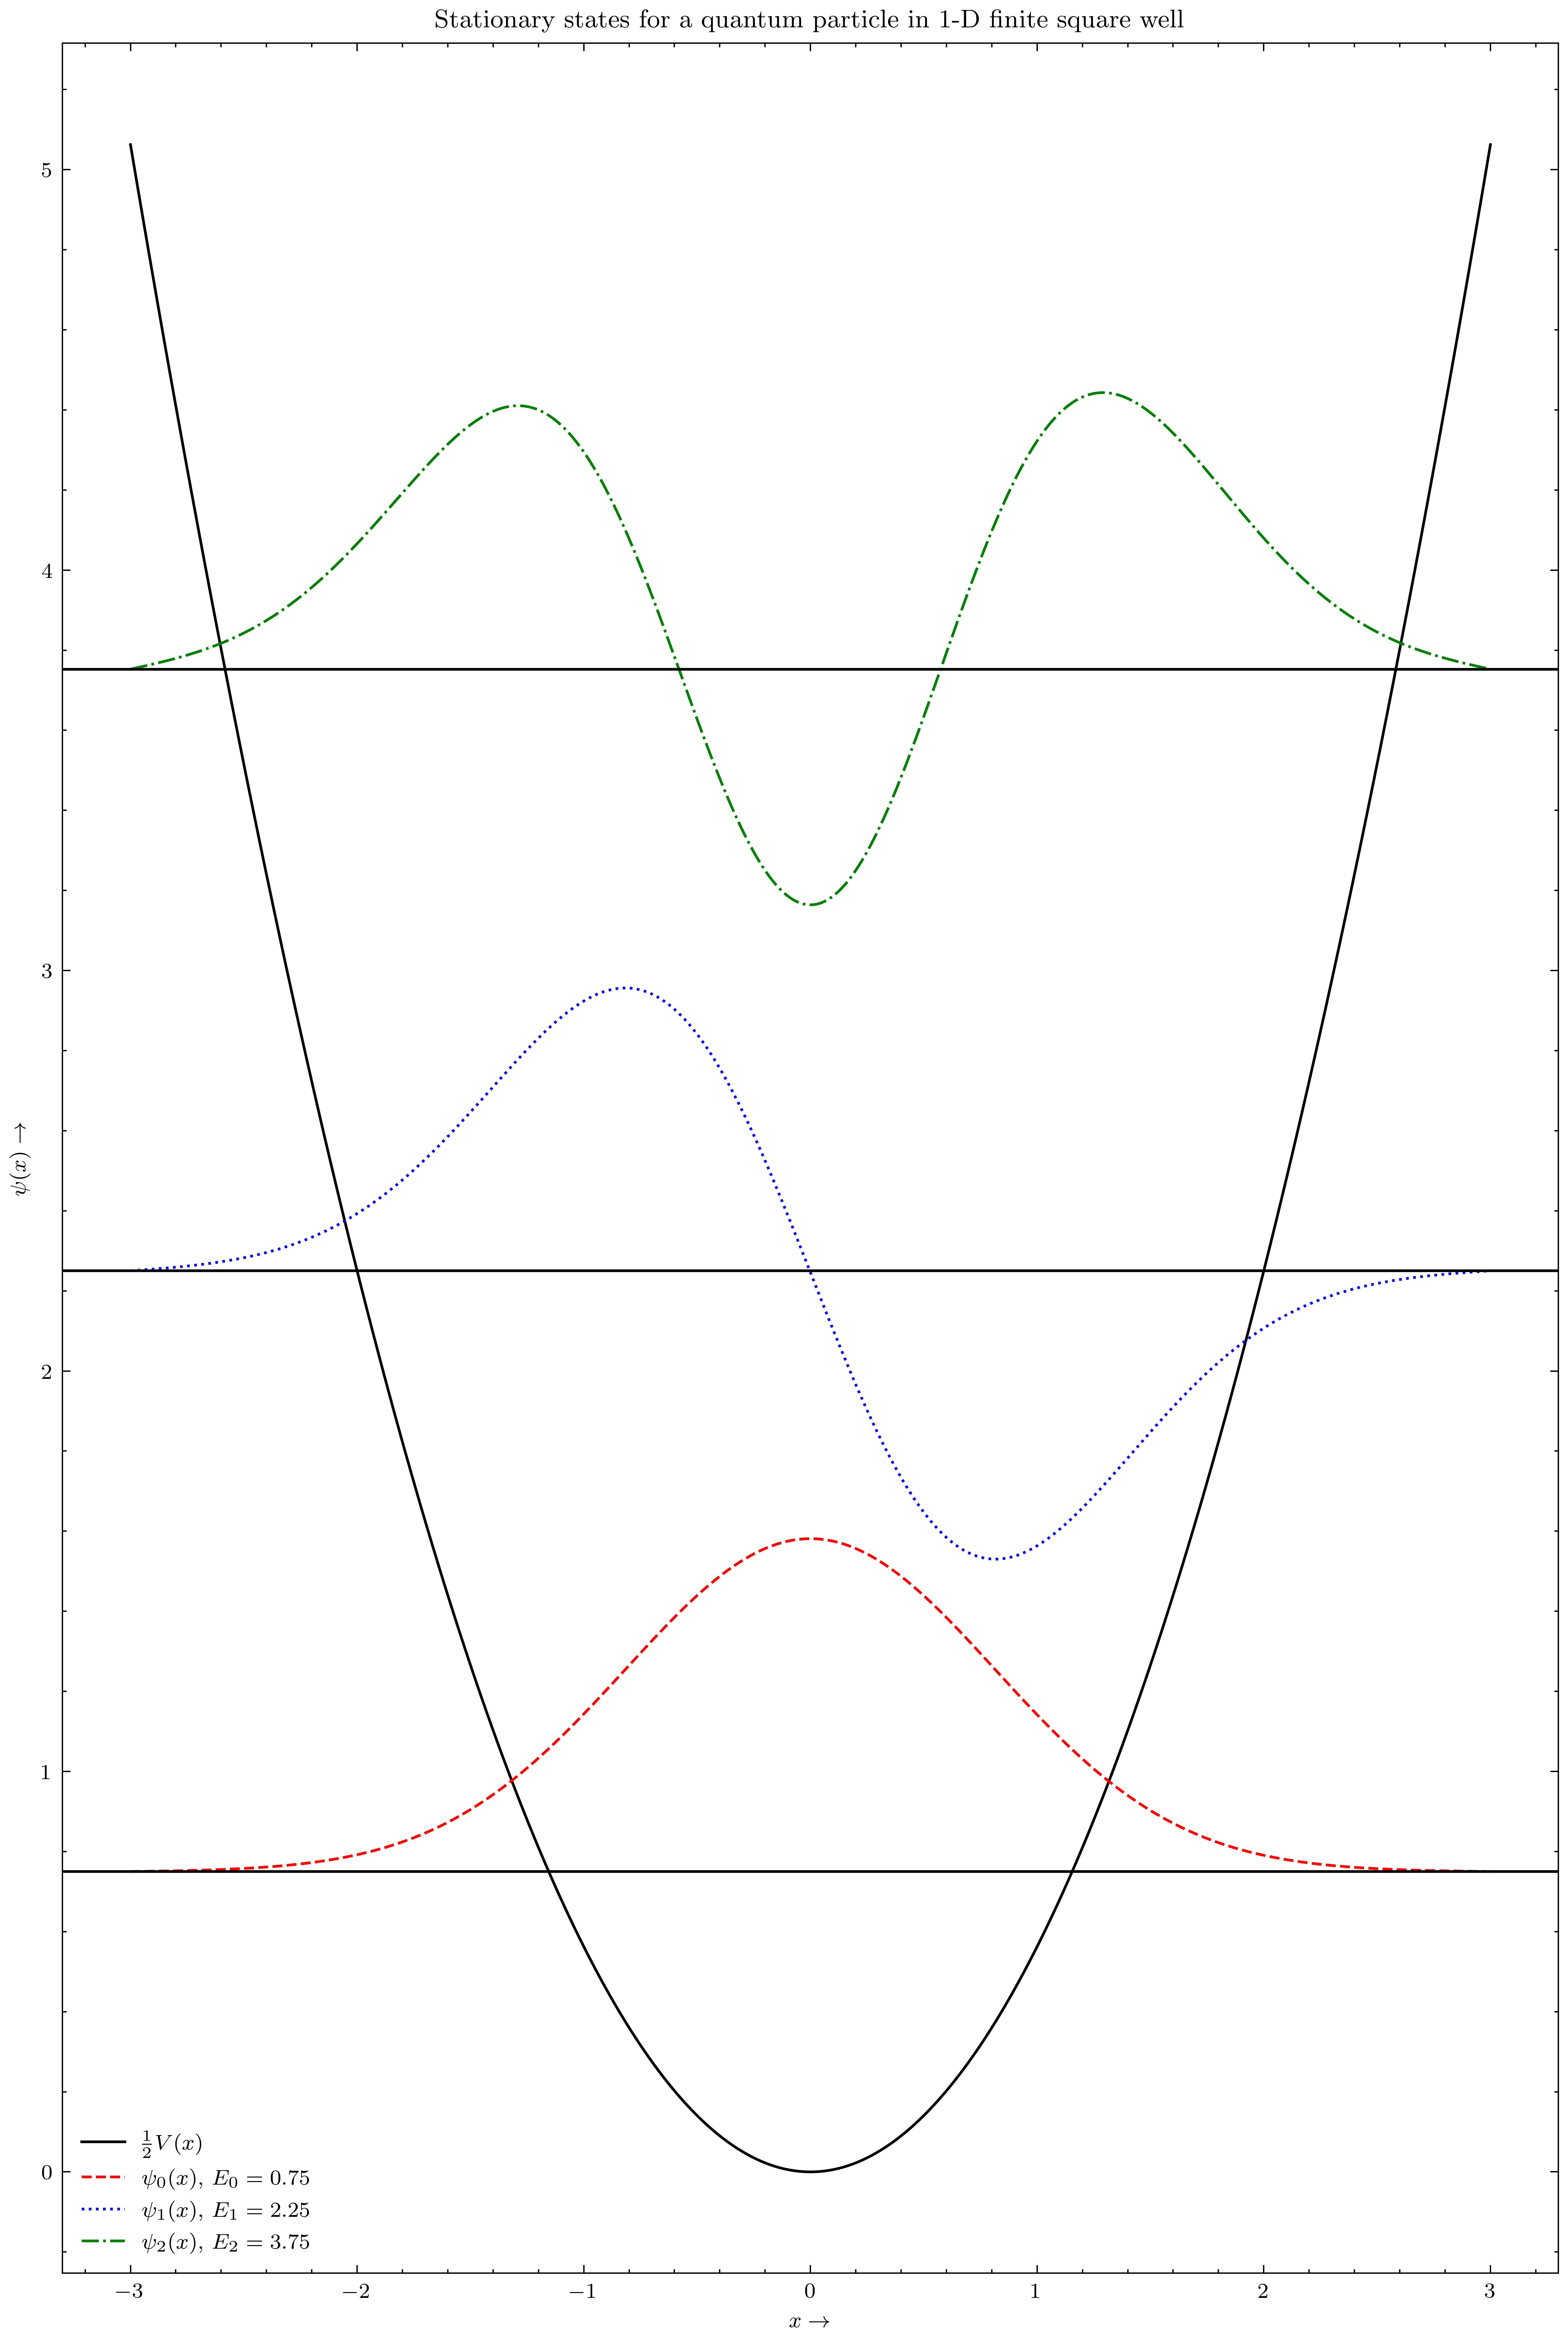

In [17]:
plt.plot(x, 0.5*V(x), label="$\\frac{1}{2} V(x)$")

for i in range(E.size):
    plt.plot(x , E[i] + psi[i]/np.sqrt(integrate.simpson(psi[i]**2, x)), label=f"$\psi_{i}(x)$, $E_{i} = {round(E[i], 2)}$")
    plt.axhline(E[i])

plt.title("Stationary states for a quantum particle in 1-D finite square well")
plt.xlabel("$x \\rightarrow$")
plt.ylabel("$\psi(x) \\rightarrow$")
plt.legend()
plt.show()

### Barier Potential

$$
V(x)
=
\begin{cases}
V_0, & 0 < x \le a\\
0, & \text{otherwise}
\end{cases}
$$

In [18]:
a = 0.1
V_0 = 100.0

@np.vectorize
def V(x):
    if 0 < x <= a:
        return V_0
    else:
        return 0.0

xi, xf = -1, 1
E_n = 3

x, E, psi = solve_sch_eqn(sch_eqn(V), xi, xf, E_n)

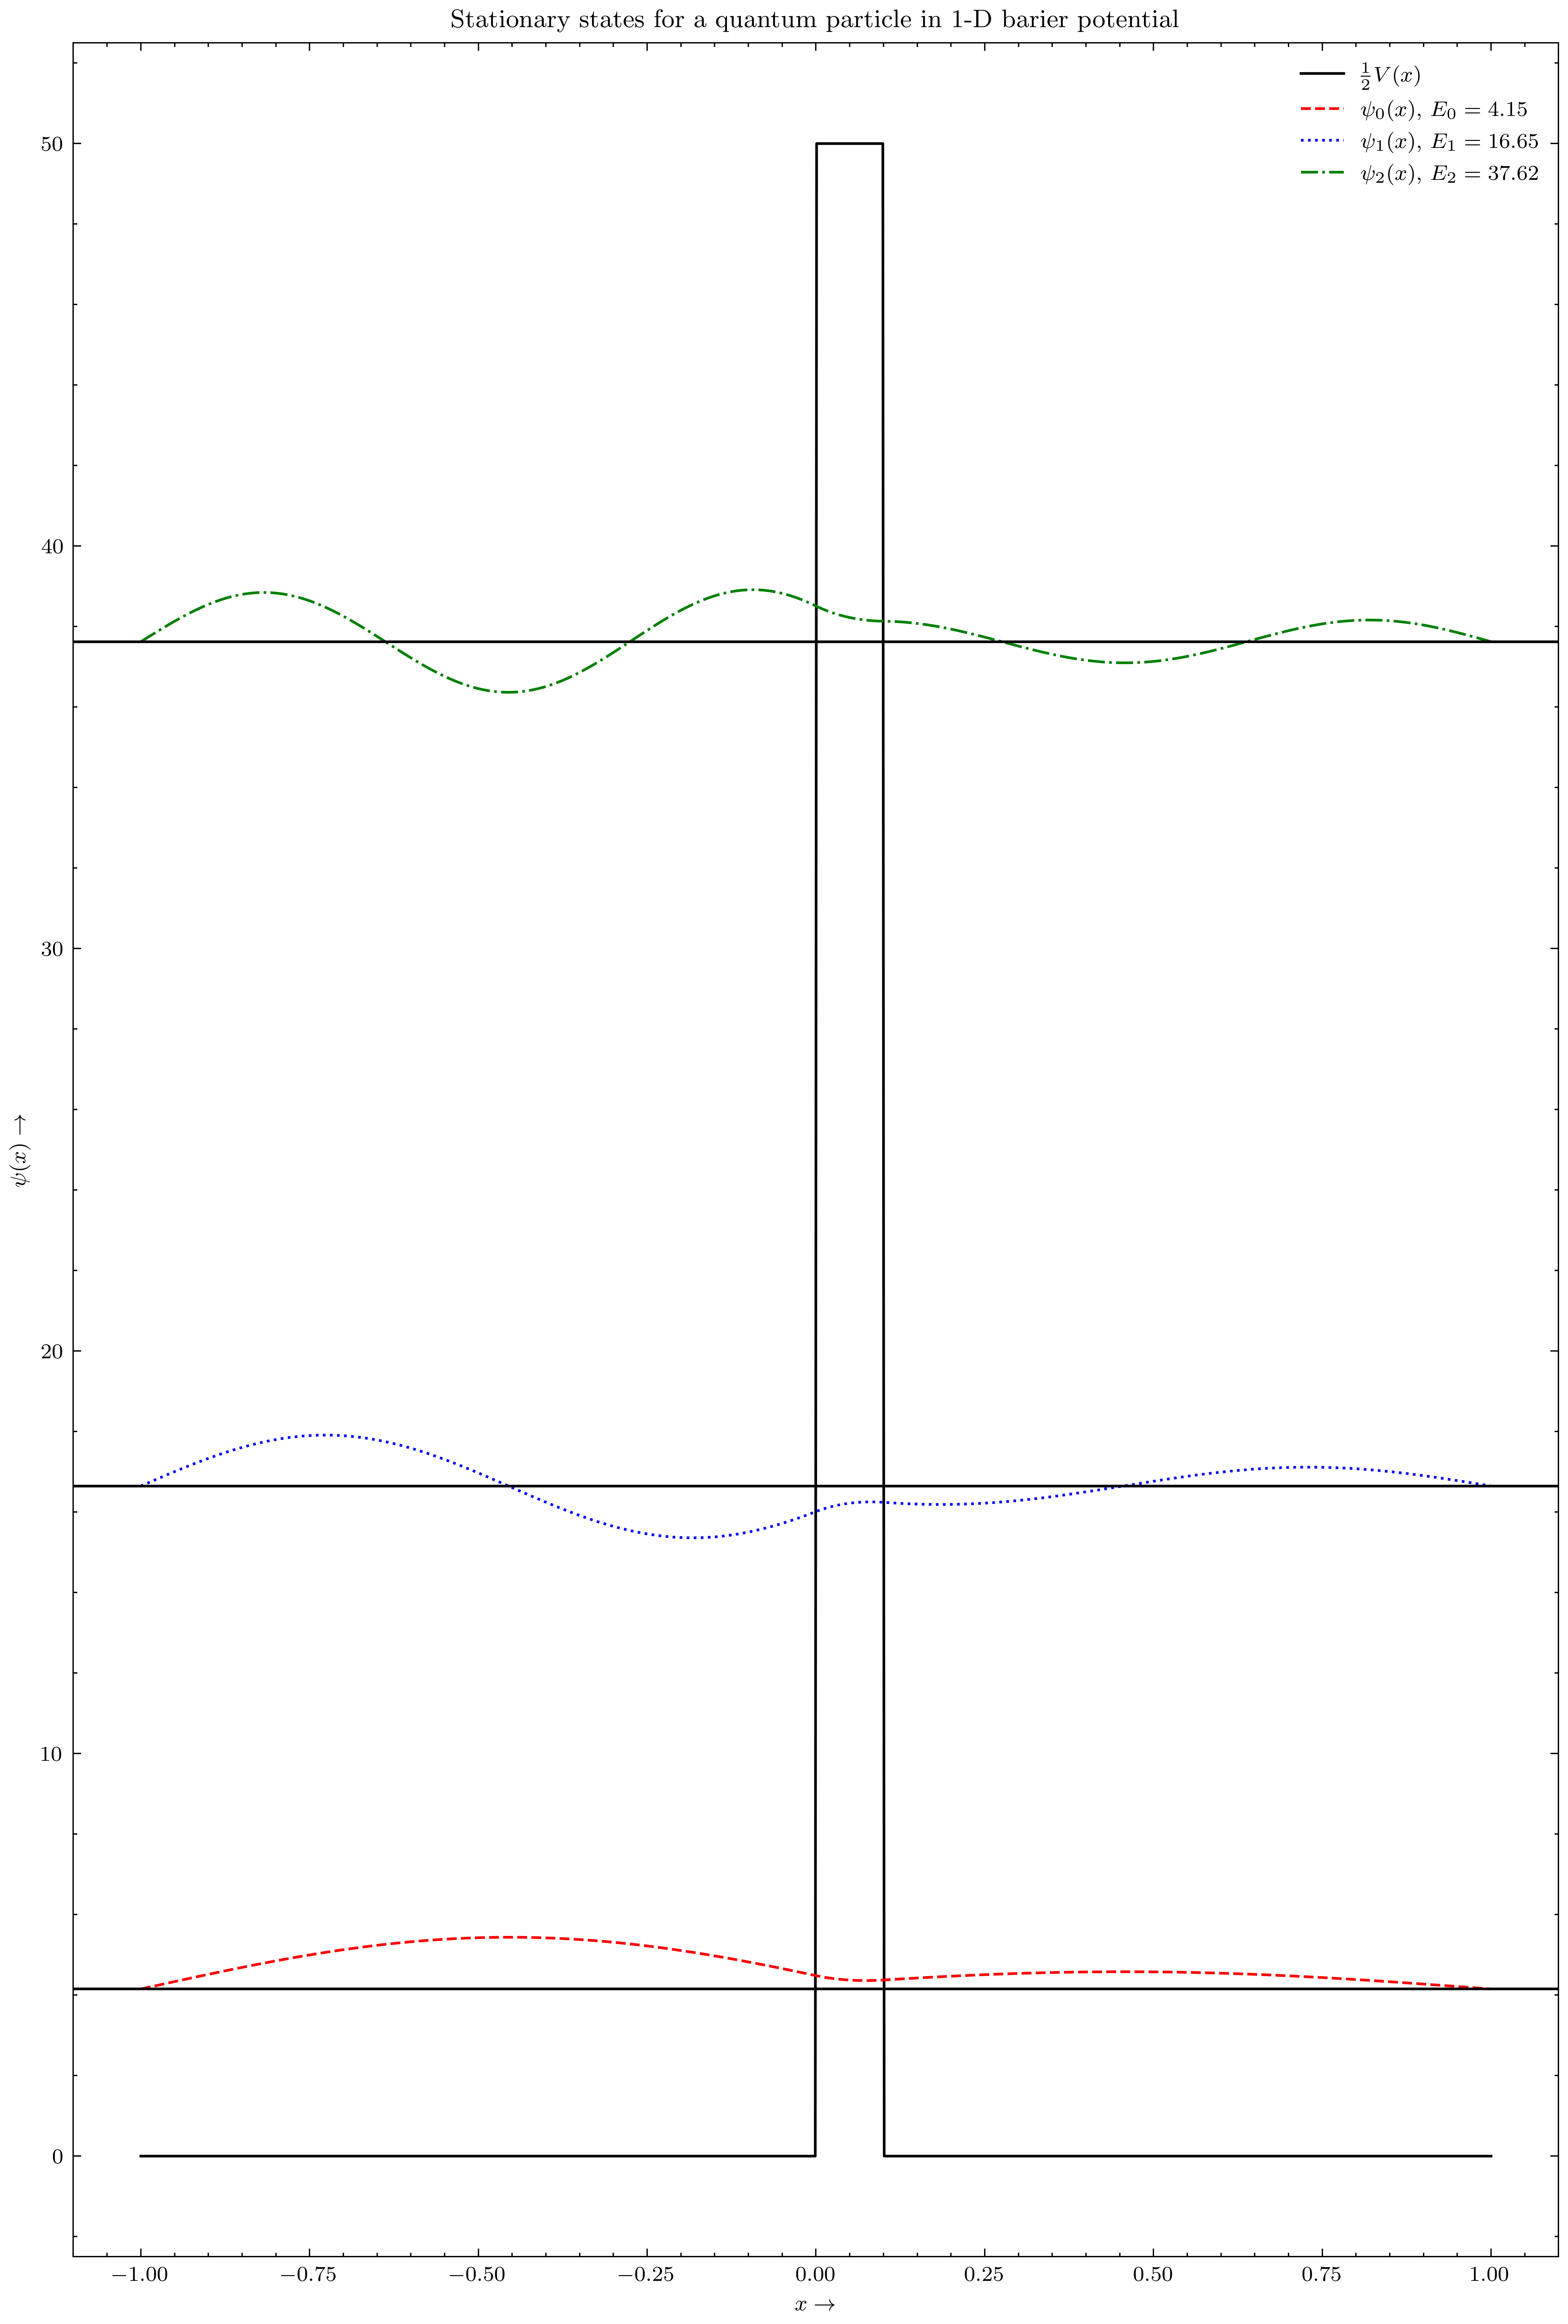

In [19]:
plt.plot(x, 0.5 * V(x), label="$\\frac{1}{2}V(x)$")

for i in range(E_n):
    plt.plot(x, E[i] + psi[i]/np.sqrt(integrate.simpson(psi[i]**2, x)), label=f"$\psi_{i}(x)$, $E_{i} = {round(E[i], 2)}$")
    plt.axhline(E[i])

plt.title("Stationary states for a quantum particle in 1-D barier potential")
plt.xlabel("$x \\rightarrow$")
plt.ylabel("$\psi(x) \\rightarrow$")
plt.legend()
plt.show()